In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
n = 30
start = -2
stop = 2

x = np.linspace(start,stop,n)

eps = 1
np.random.seed(1)
r = np.random.rand(1,n) * eps

y1 = x*(np.cos(r + 0.5*x**3) + np.sin(0.5*x**3))
y2 = y = 4*x**5 - 5*x**4 - 20*x**3 + 10*x**2 + 40*x + 10 + r

y1 = np.ravel(y1) # flattens the array to 1D
y2 = np.ravel(y2)

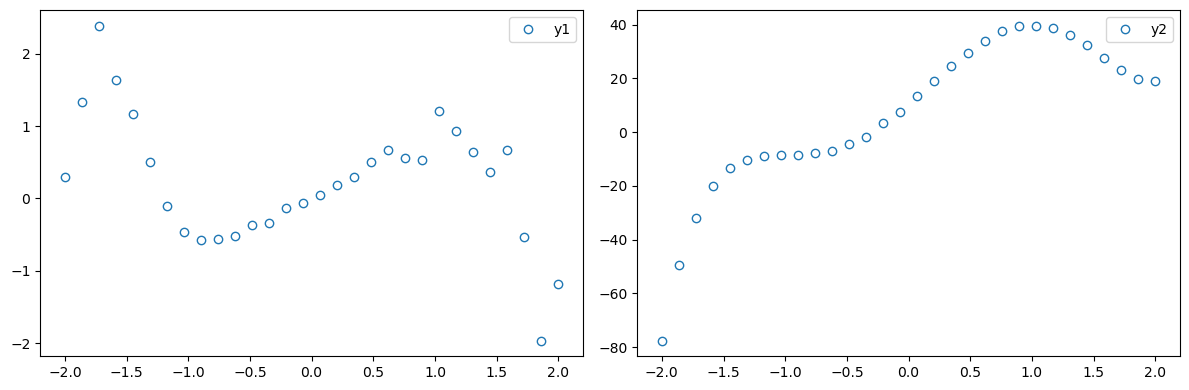

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.plot(x, y1, "o", label="y1", markerfacecolor='none')
ax1.legend()

ax2.plot(x, y2, "o", label="y2", markerfacecolor='none')
ax2.legend()

plt.tight_layout()

plt.show()
plt.close()

# Oblig 1

## MAT4110

### John-Magnus Johnsen

##### Wednesday 24. september 2025

In the first case, the idea of QR factorisation is that from:
$$
\boldsymbol{Ax} = \boldsymbol{b}
$$ 

we factorize $\boldsymbol{A}$ into a orthogonal matrix $\boldsymbol{Q}$ and an upper triangular matrix $\boldsymbol{R}$, such that $\boldsymbol{A} = \boldsymbol{QR}$, and the expression becomes:
$$
\boldsymbol{QRx} = \boldsymbol{b} 
$$

First we write:

$$
\boldsymbol{Qy} = \boldsymbol{b}
$$

Where $\boldsymbol{y} = \boldsymbol{Rx}$. Then we left-multiply both sides by $\boldsymbol{Q}^T$:

$$
\boldsymbol{Q}^T \boldsymbol{Qy} = \boldsymbol{Q}^T \boldsymbol{b}
$$

And since $\boldsymbol{Q}$ is an orthogonal matrix, it will have the much helpful property of $\boldsymbol{Q}^T = \boldsymbol{Q}^{-1}$. 

So we then get:

$$
\boldsymbol{Q}^{-1} \boldsymbol{Qy} = \boldsymbol{Q}^T \boldsymbol{b}
$$

$$
\boldsymbol{y} = \boldsymbol{Q}^T \boldsymbol{b}
$$

Now, $\boldsymbol{Q}^T \boldsymbol{b}$ is straight forward solvable, therefore easily obtain $\boldsymbol{y}$.

From this we can solve $\boldsymbol{Rx} = \boldsymbol{y}$ by back substitution, finding $\boldsymbol{x}$

In [ ]:
# 1. Find QR factorization of matrix A

def back_substitution(A, y):
    """
    Calculate x in Ax = y, by using QR factorization to get an upper triangular matrix we can use with back substitution.
    """
    # Prepare A and y for back substitution
    n = np.shape(A)[0]  # number of rows in A
    m = np.shape(A)[1]  # number of columns in A
    # Create augmented matrix Ry, shape (n, m+1)
    Ay = np.zeros((n, m+1))
    Ay[:,:m] = A
    Ay[:,-1] = y

    # The back substitution
    # Solving the system Ax = y for x by back substitution, here by using row operations, Gauss elimination, on the augmented matrix [A y], 
    # which we turn into [I ~y], having the solution x = ~y
    for i in range(n):
        # Staring from the bottom row
        # First, find the the diagonal element of A in this row, use it to divide it self and the corresponding row element in y   
        pivot = np.copy(Ay[-1-i,-2-i])  # pivot element of row this row
                
        Ay[-1-i,-2-i] /= pivot          # the pivot element equals it self divided by the pivot element
        Ay[-1-i,-1] /= pivot            # the corresponding y value equals it self divided by the pivot element

        # Second, make all column elements above the pivot element zero by row operations, also updating y accordingly
        p_col = np.copy(Ay[:-1-i,-2-i]) # array of all column elements in column -2-i above row -1-i, -1-i is excluded
        y_pivot = np.copy(Ay[-1-i,-1])  # y value corresponding to pivot element

        # add the negative value of it self for all elements above pivot, essentially setting them to zero
        Ay[:-1-i,-2-i] = Ay[:-1-i,-2-i] + (-1.0*p_col)
        
        # for each y element above y_pivot, add the value of: y_pivot times the same value used above for det pivot column,
        # this corresponds to the same row operations the row with pivot element in question makes on the above rows
        Ay[:-1-i,-1] = Ay[:-1-i,-1] + (-1.0*p_col*y_pivot)
    
    x = Ay[:,-1]
    return x

The idea behind this particularly implementation of the back substitution is to clean up the upper triangular matrix so we only have a diagonal matrix with only ones on the along the diagonal and zero elsewhere. Then the y vector should contain all the x values in perfect order corresponding to Ix = ~y.

[18.63876087 22.85345629 -8.28469214 -1.08571128]


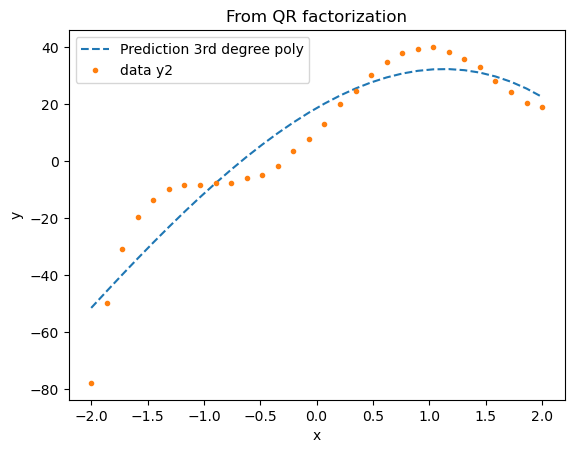

In [68]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)    # create a feature matrix containing the columns [1, x, x^2, x^3]
A = poly.fit_transform(x.reshape(-1,1))

Q, R = np.linalg.qr(A)  # numpy function calculating Q and R
y = Q.T @ y2 # matrix multiplication between the transpose of Q and vector b

xA = back_substitution(R, y)
print(xA)
pred = A @ xA

plt.plot(A[:,1], pred, "--", label="Prediction 3rd degree poly")
plt.plot(x, y2, ".", label="data y2")
plt.legend()
plt.title("From QR factorization")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

For the forward substitution we follow a more conventional algorithm, like the one presented in the book. This algorithm exploits that we for a lower triangular matrix $\boldsymbol{A}$, and $\boldsymbol{Ax} = \boldsymbol{y}$, obtain the first element of $\boldsymbol{x}$, $x_1$, from $A_{1,1} x_1 = y_1 \implies x_1 = \dfrac{y_1}{A_{1,1}}$. Then because $\boldsymbol{A}$ is lower triangular we will always be abel to find use alle the elements prior to the diagonal element for any row iteratively row by row going down the diagonal. 

In [61]:
# 2. Solve the normal equation using Cholesky factorization

def cholesky_factorization(A):
    """
    Decomposes A into a lower triangular matrix L, the diagonal matrix D, and the upper triangular matrix L.transpose
    In this case, A must be symmetric, and can't have non zero entries along the diagonal.
    Returns R, and R transposed 
    """
    # First a LDL.T composition.
    if np.shape(A)[0] != np.shape(A)[1]:
        raise ValueError("A must be square")

    n = np.shape(A)[1]  # the number of columns in A    
    L = np.zeros([n ,n])
    D = np.zeros([n, n])

    A_current = np.array(A, dtype=float)    # so to not cause int error further down the code
    for k in range(n):
        L[:,k] = np.copy(A_current[:,k])    # the k-th column of L equals the k-th column of A
        
        if L[k,k] == 0:
            raise ValueError("Matrix A might be singular or not positive definite.")    # Also prevent division by zero bellow
        
        L[:,k] /= L[k,k]                    # scale the k-th column of L with the diagonal element L[k,k]
        D[k,k] = A_current[k,k]
        A_current -= D[k,k]*np.outer(L[:,k], L[:,k].T)

    # The Cholesky factorization A = RR.T
    R = L @ np.sqrt(D)
    
    return R, R.T



def forward_substitution(A, y):
    """
    Calculate x in Ax = y, where A is an lower triangular matrix, by forward substitution.
    Take lower triangular matrix A, and vector y.
    Return column vector x.
    Following the example in the book this time
    """
    n = A.shape[0]
    m = A.shape[1]
    if n != m:
        raise ValueError("A is not a square matrix")
    
    if len(y) != n:
        raise ValueError(f"y must be a vector of length {n}")
    
    x = np.zeros([n])

    if abs(A[0,0]) > 1e-12:
        x[0] = y[0]/A[0,0]
    else:
        raise ValueError("Diagonal element A[0,0] is zero")
    
    for i in range(1, n):
        if A[i,i] > 1e-12:

            temp = 0
            for j in range(0, i):
                temp = temp + A[i,j] * x[j]
            
            x[i] = (y[i] - temp/A[i,i])
        else:
            raise ValueError(f"Diagonal element A[{i},{i}] is zero")

    return x

In [7]:
A = np.array([[3, 4], [4, 6]])

R, RT = cholesky_factorization(A)
print(R @ R.T)

[[3. 4.]
 [4. 6.]]


In the second example we look at the closed form solution to the sum of squard errors between the predicted values and data, in other words the <i>normal equation</i>:
$$
\boldsymbol{A}^T \boldsymbol{A} \boldsymbol{x} = \boldsymbol{A}^T \boldsymbol{b}
$$

We then set $\boldsymbol{B} = \boldsymbol{A}^T \boldsymbol{A}$, and do a Cholesky factorization, first by having $ \boldsymbol{B} = \boldsymbol{L} \boldsymbol{D} \boldsymbol{L}^T$, where $\boldsymbol{L}$ is a lower triangular matrix and $\boldsymbol{D}$ a diagonal matrix, then since $\boldsymbol{B}$ is positive definite, $\boldsymbol{D}$ will have no negative or zero entries along the diagonal, so we can write: $\boldsymbol{D} = \boldsymbol{D}^{1/2} \boldsymbol{D}^{1/2}$, where $(\boldsymbol{D}^{1/2})_{k,k} = \sqrt{D_{k,k}}$. We have:
$$
\boldsymbol{B} = \boldsymbol{L} \boldsymbol{D}^{1/2} \boldsymbol{D}^{1/2} \boldsymbol{L}^T = (\boldsymbol{L} \boldsymbol{D}^{1/2}) \left( \boldsymbol{L} ((\boldsymbol{D}^{1/2}))^T \right)^T
$$

Which, do to $\boldsymbol{D}$ being a diagonal matrix - thus invariant under transposition: $\boldsymbol{D}^T = \boldsymbol{D}$, can be written:
$$
B = \boldsymbol{L} \boldsymbol{D}^{1/2} \left( \boldsymbol{L} \boldsymbol{D}^{1/2} \right)^T
$$

Sometimes written, with $\boldsymbol{R} = \boldsymbol{L} \boldsymbol{D}^{1/2}$, so that:
$$
\boldsymbol{B} = \boldsymbol{R} \boldsymbol{R}^T 
$$
 
The entries in $\boldsymbol{L}$ is only scaled by multiplying with $\boldsymbol{D}^{1/2}$, so $\boldsymbol{R}$ remains lower triangular, while $\boldsymbol{R}^T$ is upper triangular. This lets us go from:
$$
\boldsymbol{B} \boldsymbol{x} = \boldsymbol{A}^T \boldsymbol{b}
$$

To:
$$
\boldsymbol{R} \boldsymbol{R}^T \boldsymbol{x} = \boldsymbol{A}^T \boldsymbol{b}
$$

And like before we solve this in two steps, first by making the substitution $\boldsymbol{R}^T \boldsymbol{x} = y$:
$$
\boldsymbol{R} \boldsymbol{y} = \boldsymbol{A}^T \boldsymbol{b}
$$

Solving for $\boldsymbol{y}$ through <u>forward substitution</u> (since $\boldsymbol{R}$ i lower triangular, and $\boldsymbol{A}^T \boldsymbol{b}$ easily can be computed), and then once we have $\boldsymbol{y}$ we can solve:
$$
\boldsymbol{R}^T \boldsymbol{x} = y
$$
through <u>back substitution</u> (since $\boldsymbol{R}^T$ is upper triangular), finally obtaining $\boldsymbol{x}$.

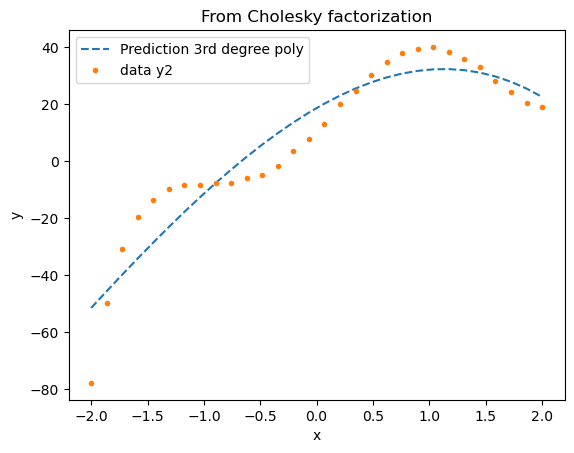

In [69]:
B = A.T @ A

R, RT = cholesky_factorization(B)

y_chol = forward_substitution(R, A.T@y2)

x_pred = back_substitution(RT, y_chol)

pred2 = A @ x_pred

plt.plot(A[:,1], pred, "--", label="Prediction 3rd degree poly")
plt.plot(x, y2, ".", label="data y2")
plt.legend()
plt.title("From Cholesky factorization")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

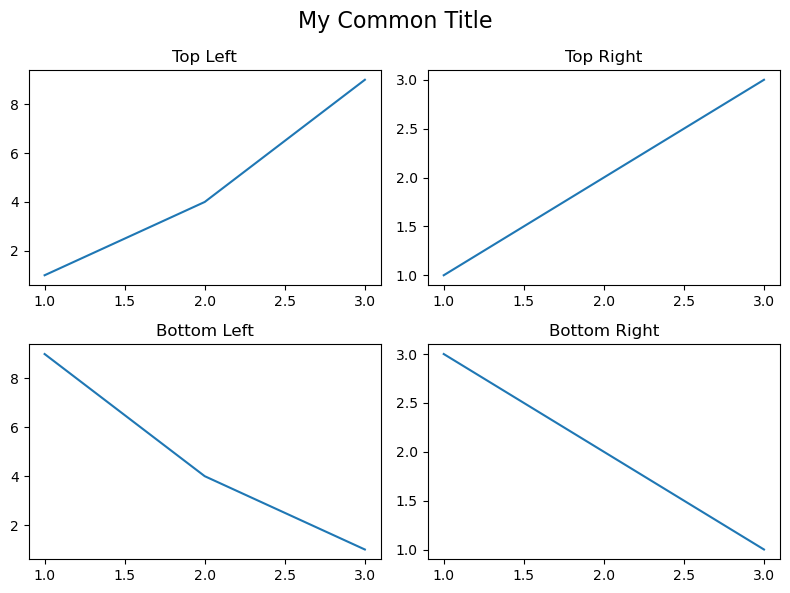

In [60]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Plot something in each subplot
axs[0, 0].plot([1, 2, 3], [1, 4, 9])
axs[0, 1].plot([1, 2, 3], [1, 2, 3])
axs[1, 0].plot([1, 2, 3], [9, 4, 1])
axs[1, 1].plot([1, 2, 3], [3, 2, 1])

# Add individual titles if needed
axs[0, 0].set_title("Top Left")
axs[0, 1].set_title("Top Right")
axs[1, 0].set_title("Bottom Left")
axs[1, 1].set_title("Bottom Right")

# Add a common title
fig.suptitle("My Common Title", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Adjust to make room for the suptitle
plt.show()
